In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem.porter import PorterStemmer
import pickle

In [18]:
dataset = pd.read_csv("Data.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [19]:
print(f"Shape of dataset: {dataset.shape}")
print(f"Dataset Info: \n{dataset.info()}")
print(f"Missing values: \n{dataset.isnull().sum()}")

Shape of dataset: (3522, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   University          3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB
Dataset Info: 
None
Missing values: 
Course Name           0
University            0
Difficulty Level      0
Course Rating         0
Course URL            0
Course Description    0
Skills                0
dtype: int64


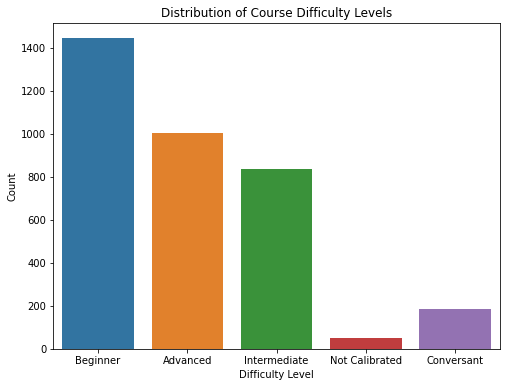

In [20]:
plt.figure(figsize=(8,6))
sns.countplot(x='Difficulty Level', data=dataset)
plt.title("Distribution of Course Difficulty Levels")
plt.xlabel('Difficulty Level')
plt.ylabel('Count')
plt.show()

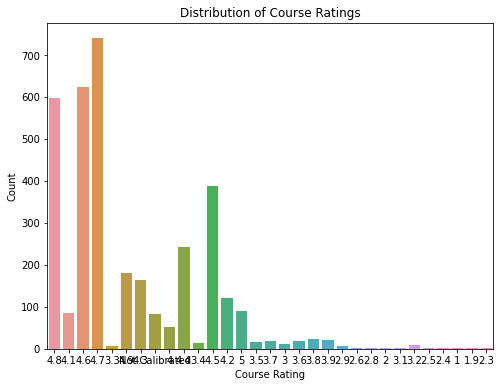

In [21]:
plt.figure(figsize=(8,6))
sns.countplot(x='Course Rating', data=dataset)
plt.title("Distribution of Course Ratings")
plt.xlabel('Course Rating')
plt.ylabel('Count')
plt.show()

In [22]:
dataset = dataset[['Course Name', 'Difficulty Level', 'Course Description', 'Skills']]


In [23]:
dataset['Course Name'] = dataset['Course Name'].str.replace(' ', ',').str.replace(',,', ',').str.replace(':', '')
dataset['Course Description'] = dataset['Course Description'].str.replace(' ', ',').str.replace(',,', ',').str.replace('_', '').str.replace(':', '').str.replace('(', '').str.replace(')', '')
dataset['Skills'] = dataset['Skills'].str.replace('(', '').str.replace(')', '')

In [24]:
dataset['tags'] = dataset['Course Name'] + dataset['Difficulty Level'] + dataset['Course Description'] + dataset['Skills']
print("Tags column created successfully.")

Tags column created successfully.


In [25]:
recommendation_df = dataset[['Course Name', 'tags']]
recommendation_df['tags'] = recommendation_df['tags'].str.replace(',', ' ').apply(lambda x: x.lower())
recommendation_df['Course Name'] = recommendation_df['Course Name'].str.replace(',', ' ')
recommendation_df.rename(columns={'Course Name': 'course_name'}, inplace=True)
print(f"New DataFrame for recommendations created with shape: {recommendation_df.shape}")

New DataFrame for recommendations created with shape: (3522, 2)


c:\Users\DELL\anaconda3\envs\myenv1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\DELL\anaconda3\envs\myenv1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\DELL\anaconda3\envs\myenv1\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [26]:
cv = CountVectorizer(max_features=5000, stop_words='english')
vectorized_text = cv.fit_transform(recommendation_df['tags']).toarray()
print("Text vectorization completed.")

Text vectorization completed.


In [27]:
ps = PorterStemmer()
def stem_text(text):
    return " ".join([ps.stem(word) for word in text.split()])

In [28]:
recommendation_df['tags'] = recommendation_df['tags'].apply(stem_text)
print("Stemming process completed on tags.")

Stemming process completed on tags.


c:\Users\DELL\anaconda3\envs\myenv1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
cosine_sim = cosine_similarity(vectorized_text)
print("Cosine similarity matrix created.")

Cosine similarity matrix created.


In [30]:
def recommend_courses(course_name):
    try:
        course_index = recommendation_df[recommendation_df['course_name'] == course_name].index[0]
        course_distances = cosine_sim[course_index]
        recommended_courses = sorted(list(enumerate(course_distances)), reverse=True, key=lambda x: x[1])[1:7]

        print(f"Recommended courses similar to '{course_name}':")
        for i in recommended_courses:
            print(recommendation_df.iloc[i[0]].course_name)
    except IndexError:
        print(f"Course '{course_name}' not found in the dataset.")

In [31]:

recommend_courses('Business Strategy Business Model Canvas Analysis with Miro')

Recommended courses similar to 'Business Strategy Business Model Canvas Analysis with Miro':
Product Development Customer Persona Development with Miro
Product and Service Development Empathy Mapping with Miro
Product Development Customer Journey Mapping with Miro
Analyzing Macro-Environmental Factors Using Creately
Business Strategy in Practice (Project-centered Course)
Innovating with the Business Model Canvas


In [32]:
os.makedirs('models', exist_ok=True)
pickle.dump(cosine_sim, open('models/cosine_similarity_model.pkl', 'wb'))
pickle.dump(recommendation_df.to_dict(), open('models/course_list.pkl', 'wb'))
pickle.dump(recommendation_df, open('models/courses.pkl', 'wb'))


print("Model and Data exported successfully.")

Model and Data exported successfully.


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import sigmoid_kernel
import difflib

In [34]:
data = pd.read_csv('Dataset.csv')
print("Dataset loaded successfully.")
print("First five rows of the dataset:")
print(data.head())

Dataset loaded successfully.
First five rows of the dataset:
                                         Course Name  \
0  Write A Feature Length Screenplay For Film Or ...   
1  Business Strategy: Business Model Canvas Analy...   
2                      Silicon Thin Film Solar Cells   
3                               Finance for Managers   
4       Retrieve Data using Single-Table SQL Queries   

                  University Difficulty Level Course Rating  \
0  Michigan State University         Beginner           4.8   
1   Coursera Project Network         Beginner           4.8   
2         cole Polytechnique         Advanced           4.1   
3       IESE Business School     Intermediate           4.8   
4   Coursera Project Network         Beginner           4.6   

                                          Course URL  \
0  https://www.coursera.org/learn/write-a-feature...   
1  https://www.coursera.org/learn/canvas-analysis...   
2  https://www.coursera.org/learn/silicon-thin-fi...   

In [35]:
print("\nDataset Info:")
print(data.info())
print("\nChecking for missing values:")
print(data.isnull().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   University          3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB
None

Checking for missing values:
Course Name           0
University            0
Difficulty Level      0
Course Rating         0
Course URL            0
Course Description    0
Skills                0
dtype: int64


In [36]:
processed_data = data.copy()
processed_data.drop(['University', 'Difficulty Level', 'Course Rating', 'Course URL', 'Course Description'], axis=1, inplace=True)
print("\nUnnecessary columns dropped. Columns retained:")
print(processed_data.columns)


Unnecessary columns dropped. Columns retained:
Index(['Course Name', 'Skills'], dtype='object')


In [37]:
processed_data['Skills_Cleaned'] = processed_data['Skills'].fillna('')
print("\nSkills column cleaned and NaN values replaced.")



Skills column cleaned and NaN values replaced.


In [38]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word',
                                   token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data['Skills_Cleaned'])
print("\nTF-IDF vectorization applied. Shape of TF-IDF matrix:", tfidf_matrix.shape)


TF-IDF vectorization applied. Shape of TF-IDF matrix: (3522, 7499)


In [39]:
similarity_matrix = sigmoid_kernel(tfidf_matrix, tfidf_matrix)
print("\nSigmoid kernel computed. Shape:", similarity_matrix.shape)


Sigmoid kernel computed. Shape: (3522, 3522)


In [40]:
course_indices = pd.Series(processed_data.index, index=processed_data['Course Name']).drop_duplicates()
print("\nReverse mapping of indices created.")


Reverse mapping of indices created.


In [41]:
def recommend_courses(course_name, similarity_matrix=similarity_matrix):
    try:
        course_idx = course_indices[course_name]
        scores = list(enumerate(similarity_matrix[course_idx]))
        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
        top_courses = [i[0] for i in sorted_scores[1:11]]
        return data.iloc[top_courses].reset_index(drop=True)
    except KeyError:
        print("Course not found in the dataset.")
        return pd.DataFrame()

In [42]:
def search_and_recommend(keyword):
    try:
        course_list = processed_data['Course Name'].tolist()
        print(course_list)
        matches = difflib.get_close_matches(keyword, course_list)
        
        if matches:
            recommendations = recommend_courses(matches[0])

            if recommendations.empty:
                print("\nSorry! No matching courses found. Try refining your search.")
            else:
                print("\nHere are some recommendations based on your search:")
                print(recommendations)
        else:
            print("\nNo matching courses found for the given keyword.")
    except Exception as e:
        print("\nAn error occurred:", e)

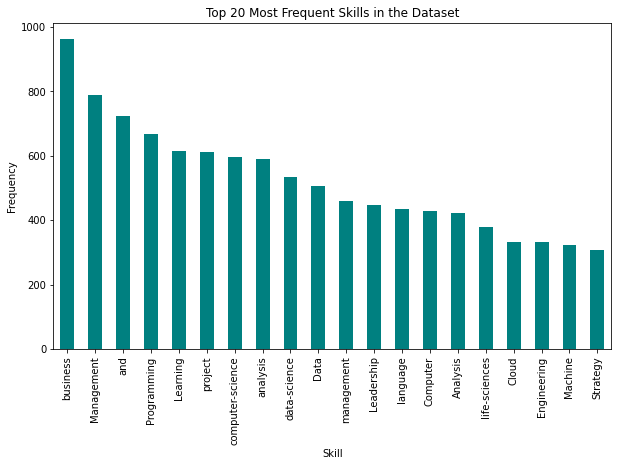

In [43]:
skills = processed_data['Skills_Cleaned'].str.split().explode().value_counts().head(20)
plt.figure(figsize=(10, 6))
skills.plot(kind='bar', color='teal')
plt.title('Top 20 Most Frequent Skills in the Dataset')
plt.xlabel('Skill')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


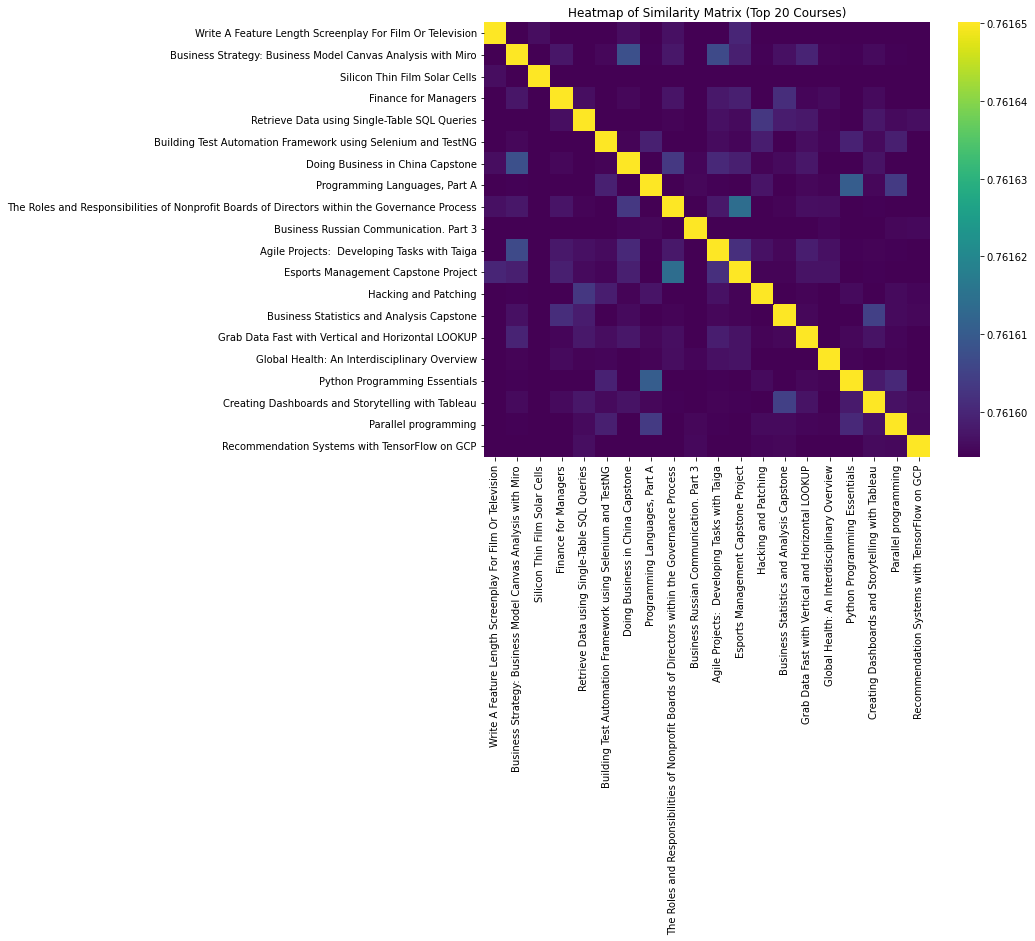

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix[:20, :20], cmap='viridis', xticklabels=processed_data['Course Name'].head(20), yticklabels=processed_data['Course Name'].head(20), annot=False)
plt.title("Heatmap of Similarity Matrix (Top 20 Courses)")
plt.show()

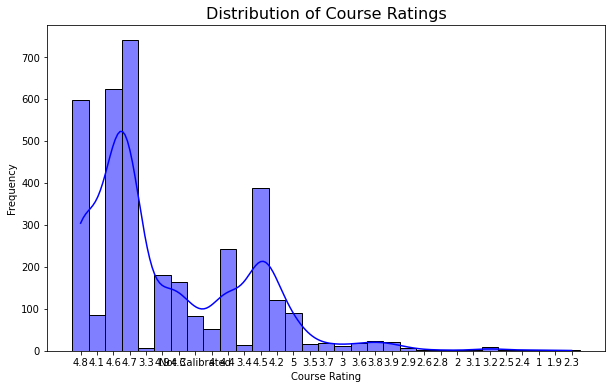

In [45]:
if 'Course Rating' in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data['Course Rating'].dropna(), bins=20, kde=True, color='blue')
    plt.title('Distribution of Course Ratings', fontsize=16)
    plt.xlabel('Course Rating')
    plt.ylabel('Frequency')
    plt.show()

In [46]:
print("\nSearching for courses related to 'voices of social change'...")
search_and_recommend('voices of social change')


Searching for courses related to 'voices of social change'...
['Write A Feature Length Screenplay For Film Or Television', 'Business Strategy: Business Model Canvas Analysis with Miro', 'Silicon Thin Film Solar Cells', 'Finance for Managers', 'Retrieve Data using Single-Table SQL Queries', 'Building Test Automation Framework using Selenium and TestNG', 'Doing Business in China Capstone', 'Programming Languages, Part A', 'The Roles and Responsibilities of Nonprofit Boards of Directors within the Governance Process', 'Business Russian Communication. Part 3', 'Agile Projects:  Developing Tasks with Taiga', 'Esports Management Capstone Project', 'Hacking and Patching', 'Business Statistics and Analysis Capstone', 'Grab Data Fast with Vertical and Horizontal LOOKUP', 'Global Health: An Interdisciplinary Overview', 'Python Programming Essentials', 'Creating Dashboards and Storytelling with Tableau', 'Parallel programming', 'Recommendation Systems with TensorFlow on GCP', 'The Changing Arcti

In [2]:
import pickle
import numpy as np
import pandas as pd

cosine_sim = pickle.load(open('models/cosine_similarity_model.pkl', 'rb'))
recommendation_dict = pickle.load(open('models/course_list.pkl', 'rb'))
recommendation_df = pickle.load(open('models/courses.pkl', 'rb'))

recommendation_df = pd.DataFrame.from_dict(recommendation_dict)

def predict_courses(course_name, top_n=5):
    try:
        course_index = recommendation_df[recommendation_df['course_name'] == course_name].index[0]

        course_distances = cosine_sim[course_index]

        recommended_courses = sorted(list(enumerate(course_distances)), reverse=True, key=lambda x: x[1])[1:top_n+1]

        print(f"\nTop {top_n} courses similar to '{course_name}':")
        for i, (idx, score) in enumerate(recommended_courses):
            recommended_course_name = recommendation_df.iloc[idx].course_name
            print(f"{i+1}. {recommended_course_name} (Similarity Score: {score:.2f})")
    except IndexError:
        print(f"Course '{course_name}' not found in the dataset.")
    except Exception as e:
        print("An error occurred during prediction:", str(e))

print("\nPredicting recommendations...")
predict_courses('Business Strategy Business Model Canvas Analysis with Miro', top_n=5)



Predicting recommendations...

Top 5 courses similar to 'Business Strategy Business Model Canvas Analysis with Miro':
1. Product Development Customer Persona Development with Miro (Similarity Score: 0.65)
2. Product and Service Development Empathy Mapping with Miro (Similarity Score: 0.63)
3. Product Development Customer Journey Mapping with Miro (Similarity Score: 0.62)
4. Analyzing Macro-Environmental Factors Using Creately (Similarity Score: 0.60)
5. Business Strategy in Practice (Project-centered Course) (Similarity Score: 0.59)
